# Task 2
## Introduction
### What to do
- Prepare 4 random 4-qubit quantum states of your choice.
- Create and train a variational circuit that transforms input states into predefined output states. Namely:
    - if random state 1 is provided, it returns state |0011>
    - if random state 2 is provided, it returns state |0101>
    - if random state 3 is provided, it returns state |1010>
    - if random state 4 is provided, it returns state |1100>

What would happen if you provided a different state?

Analyze and discuss the results.

For the variational circuit, you can try any circuit you want. You can start from one with a layer of RX, RY and CNOTs, repeated a couple of times (though there are certainly better circuits to achieve this goal). 

### Goals
- Coding skills – clear, readable, well-structured code    
- Communication – well-described results, easy to understand, tidy.
- Reliability – submitted on time, all the points from the task description are met
- Research skills – asking good questions and answering them methodically

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table


## My solution
### State preparation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit import execute
qs = Aer.get_backend('qasm_simulator')

First, I'll create the 4 random 4-qubit states:

In [28]:
np.random.seed(0)

output_states = ['0011','0101','1010','1100']
random_states = []
for i in range(len(output_states)):
    state = np.random.randint(2, size=4)
    random_states.append(state)

print(random_states)



[array([0, 1, 1, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 0]), array([0, 1, 0, 0])]


Now, these random states should be taken as input and return the output states such that:

$$
\ket{0110} \rightarrow \ket{0011} \\
\ket{1111} \rightarrow \ket{0101} \\
\ket{1110} \rightarrow \ket{1010} \\
\ket{0100} \rightarrow \ket{1100}
$$

## The learning pipeline

Following the first paper by Benedetti et al., I will be using these variables:
- $\mathcal{D} = \left( \vec{x_1}, \dots, \vec{x_D} \right)$ where $D$ is a collection of independent and identically distributed random vectors.
- $\vec{x_d} \in {-1,+1}^N$ are N-dimensional binary vectors.

And using these we can get an intuitive one-to-one mapping between observation vectors and the computational basis of an N-qubit quantum system, that is $\vec{x} \longleftrightarrow \ket{\vec{x}} = \ket{x_1x_2 \dots x_N} $.

Provided with the dataset $\mathcal{D}$, the goal is to obtain a good approximation to the target probability distribution $P_\mathcal{D}$.

A quantum circuit model with fixed depth and gate layout, parameterized by a vector $\vec{\theta}$, prepares a wave function $\ket{\psi(\vec{\theta})}$ from which probabilities are obtained according to Born's rule.

Born's rule:

$$
P_\theta(\vec{x}) = \left| \braket{\vec{x}|\psi(\vec{\theta})} \right| ^2
$$

The general parameterized circuit follows the following form:

- Parameterized by:
  - Single-qubit rotations $ \{ \theta_i^{(l,k)} \} $.
  - Two-qubit entangling rotations $ \{\theta_{ij}^{(l)}\} $.
  - Note: The subscripts denote qubits involved in the operation, $l$ denotes the layer number, and $k\in\{1,2,3\}$ denotes the rotation identifier.

In [82]:
layers = 10
qubits = 4
measurements = 8000

### Theta vector

In [83]:
def theta_vectors_generator(layers, qubits):
    thetas = []
    for layer in range(layers):
        vector = ParameterVector('θ_{}'.format(str(layer)), qubits)
        thetas.append(vector)
    return thetas
theta_vectors = theta_vectors_generator(layers, qubits)

### DDQCL circuit

In [84]:
def ddqcl(layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for layer in range(layers):
        for i in range(qubits):
            qc.rx(theta_vectors[layer].params[i], i)
            qc.rz(theta_vectors[layer].params[i], i)
            for j in range(i+1, qubits):
                qc.rxx(theta_vectors[layer].params[i], i, j)
        qc.barrier()
    return qc

In [85]:
test_circuit = ddqcl(layers, qubits)

In [111]:
def theta_values_generator(layers, qubits):
    parameters = []
    for layer in range(layers):
        for qubit in range(qubits):
            #for i in (-(qubit)/2)*np.random.uniform(-np.pi,np.pi,[1]):
            # The RX(\theta) Qiskit gate divides by 2 so I will skip that
            for i in -(qubit-0.001)*np.random.uniform(-np.pi,np.pi,[1]):
                parameters.append(i)
    return parameters

generated_parameters = theta_values_generator(layers,qubits)
parameterized_test_circuit = test_circuit.bind_parameters(generated_parameters)
parameterized_test_circuit.measure(0,0)
parameterized_test_circuit.measure(1,1)
parameterized_test_circuit.measure(2,2)
parameterized_test_circuit.measure(3,3)

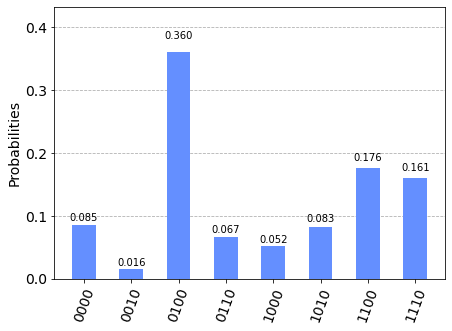

In [112]:
test_job = execute(parameterized_test_circuit, qs, shots = measurements, seed = 1000)
result = test_job.result()
counts = result.get_counts()
plot_histogram(counts)

In [113]:
print(random_states)

[array([0, 1, 1, 0]), array([1, 1, 1, 1]), array([1, 1, 1, 0]), array([0, 1, 0, 0])]


In [114]:
def cost_function(qubits, epsilon, random_states, counts):
    sum_of_ln = 0
    for i in range(qubits):
        number_string = ''
        for number in random_states[i]:
            number_string += str(number)
        #print(number_string)
        sum_of_ln += np.log(np.maximum(epsilon, counts.get(number_string, epsilon)/measurements))
    result = (-1/qubits)*sum_of_ln
    return result

calculated_cost = cost_function(qubits, 0.01, random_states, counts)
print(calculated_cost)


2.5403091294517997


Cost: 2.4445112592114033 and parameters:
[0.001720416410859068, 0.25586188024296375, 2.9720708785539984, 1.8039214086034263, -0.0015617160323925592, 2.2767647323569924, 1.1124053001698955, 1.273367607344346, 0.0017793660875524361, 2.1656106057715574, -4.68933833715983, 8.690280434787743, 0.0030337612043834826, 1.5174774921733052, 2.210335119177691, -0.5027294144163867, -0.0004206934149741488, 1.6128976707722318, 1.3510667442950985, -4.194384074371987, -0.0024307226746146647, -2.5787548618318517, 4.211249034473009, 3.9107472133499543, 0.0014449190107157514, -0.057055787813828904, 4.759997162993226, 2.7915573548975314, 0.0007991384610163799, 0.9687760294625052, -3.283968056982573, -0.9637513704991669, 0.002859690359145703, 2.8812268403625807, -5.268844742838525, 7.154330332623773, 0.0019142244041848464, -2.4227020273540916, 0.7051582714326048, -7.468574242201246]
Cost: 2.357956624078028 and parameters:
[-0.0019063033412444975, -0.9688328489594425, -4.855235855451189, -3.292573258971884, 

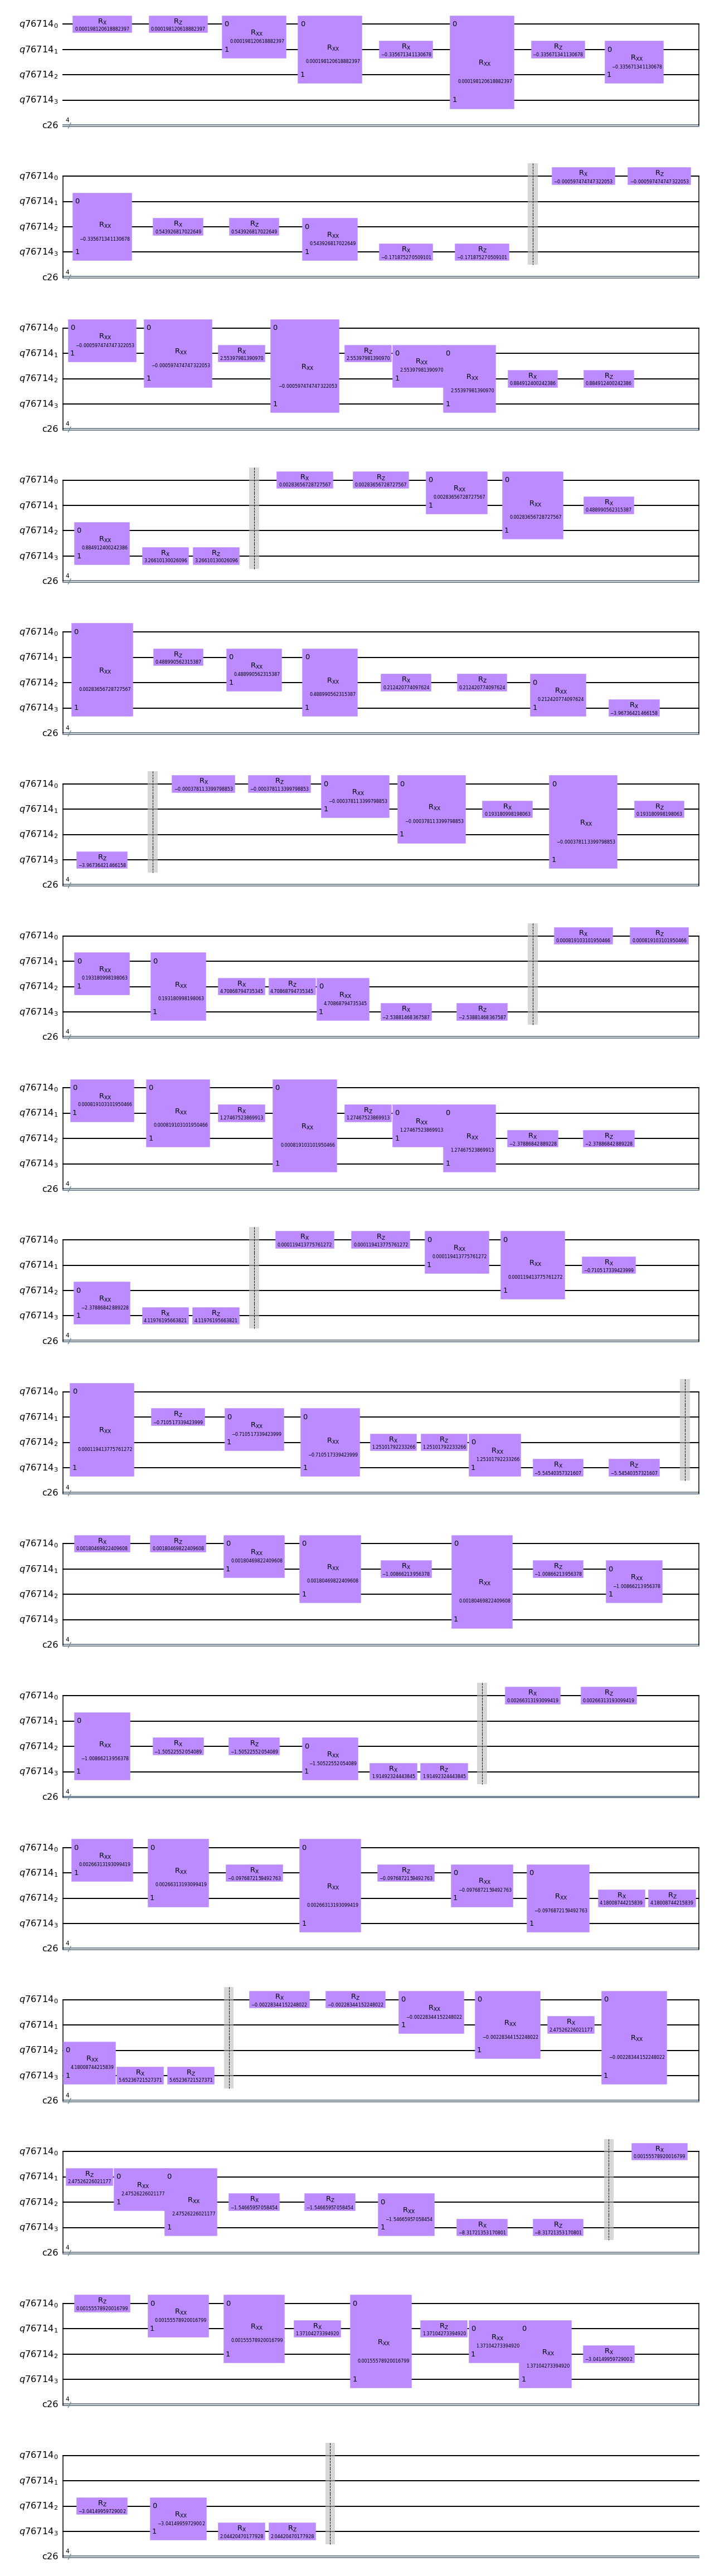

In [115]:
epsilon = 0.05

def theta_optimizer(layers, qubits, best_cost, iterations):
    cost_history = [0]
    generated_parameters = [0]
    for i in range(iterations):
        new_theta_vectors = theta_vectors_generator(layers, qubits)
        new_generated_parameters = theta_values_generator(layers,qubits)
        parameterized_new_circuit = test_circuit.bind_parameters(new_generated_parameters)
        parameterized_new_circuit.measure(0,0)
        parameterized_new_circuit.measure(1,1)
        parameterized_new_circuit.measure(2,2)
        parameterized_new_circuit.measure(3,3)
        new_circuit_job = execute(parameterized_new_circuit, qs, shots = measurements, seed = 1000)
        new_result = new_circuit_job.result()
        new_counts = new_result.get_counts()
        new_cost = cost_function(qubits, epsilon, random_states, new_counts)
        cost_history.append(new_cost)
        generated_parameters.append(new_generated_parameters)
        if new_cost < best_cost:
            print("Cost: " + str(new_cost) + " and parameters:")
            print(new_generated_parameters)
            best_cost = new_cost
    parameterized_best_circuit = test_circuit.bind_parameters(generated_parameters[-1])
    return parameterized_best_circuit, generated_parameters[-1]

last_circuit, best_parameters = theta_optimizer(layers, qubits, calculated_cost, 10000)
last_circuit.draw('mpl')


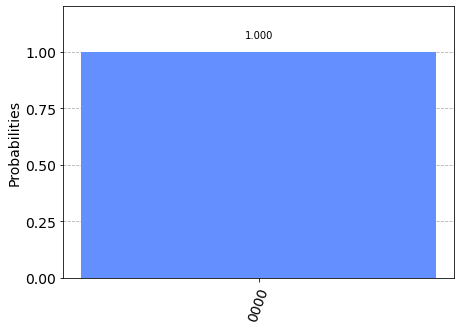

In [116]:
last_job = execute(last_circuit, qs, shots = measurements, seed = 1000)
last_result = last_job.result()
last_counts = last_result.get_counts()
plot_histogram(last_counts)

In [117]:
def initialized_ddqcl(state_vector, layers, qubits):
    qr = QuantumRegister(qubits)
    cr = ClassicalRegister(qubits)
    qc = QuantumCircuit(qr, cr)
    for i in range(len(state_vector)):
        if state_vector[i] == 1:
            qc.x(i)
    for layer in range(layers):
        for i in range(qubits):
            qc.rx(theta_vectors[layer].params[i], i)
            qc.rz(theta_vectors[layer].params[i], i)
            for j in range(i+1, qubits):
                qc.rxx(theta_vectors[layer].params[i], i, j)
        qc.barrier()
    return qc

In [118]:
def get_counts_for_state(state, parameters):
    ddqcl = initialized_ddqcl(state, layers, qubits)
    ddqcl = ddqcl.bind_parameters(parameters)
    ddqcl.measure(0,0)
    ddqcl.measure(1,1)
    ddqcl.measure(2,2)
    ddqcl.measure(3,3)
    ddqcl.draw('mpl')
    ddqcl_job = execute(ddqcl, qs, shots = measurements, seed = 1000)
    ddqcl_result = ddqcl_job.result()
    ddqcl_counts = ddqcl_result.get_counts()
    return ddqcl_counts

Output values for input state [0 1 1 0] which should give 0011:


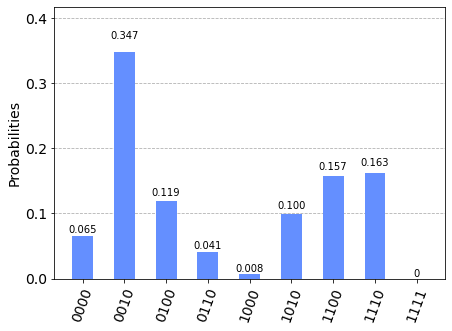

In [119]:
counts_0 = get_counts_for_state(random_states[0], best_parameters)
print("Output values for input state " + str(random_states[0]) +" which should give " + output_states[0] + ":")
plot_histogram(counts_0)

Output values for input state [1 1 1 1] which should give 0101:


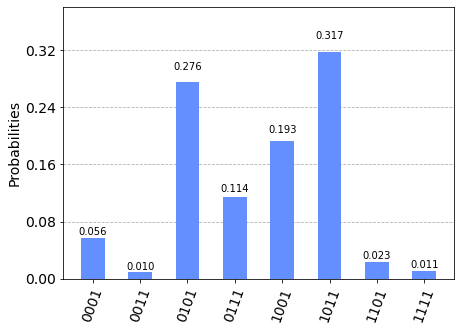

In [120]:
counts_1 = get_counts_for_state(random_states[1], best_parameters)
print("Output values for input state " + str(random_states[1]) +" which should give " + output_states[1] + ":")
plot_histogram(counts_1)

Output values for input state [1 1 1 0] which should give 1010:


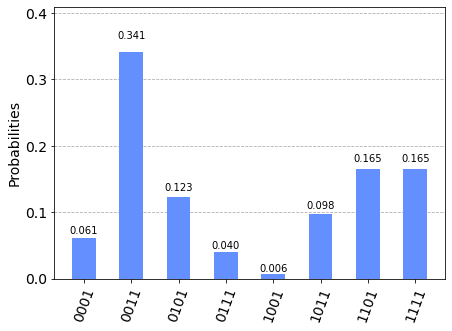

In [121]:
counts_2 = get_counts_for_state(random_states[2], best_parameters)
print("Output values for input state " + str(random_states[2]) +" which should give " + output_states[2] + ":")
plot_histogram(counts_2)

Output values for input state [0 1 0 0] which should give 1100:


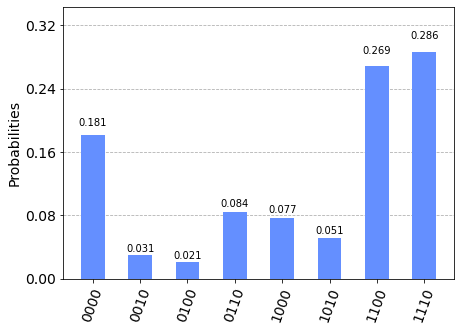

In [122]:
counts_3 = get_counts_for_state(random_states[3], best_parameters)
print("Output values for input state " + str(random_states[3]) +" which should give " + output_states[3] + ":")
plot_histogram(counts_3)

# Second approach

In [123]:
print(best_parameters)

[0.0001981206188823972, -0.33567134113067787, 0.5439268170226488, -0.17187527050910084, -0.0005974747473220527, 2.5539798139096996, 0.8849124002423865, 3.266101300260958, 0.002836567287275668, 0.48899056231538746, 0.2124207740976241, -3.967364214661585, -0.00037811339979885306, 0.1931809981980632, 4.708687947353448, -2.5388146836758665, 0.0008191031019504665, 1.2746752386991294, -2.378868428892283, 4.119761956638212, 0.00011941377576127232, -0.7105173394239985, 1.2510179223326618, -5.545403573216072, 0.0018046982240960841, -1.008662139563783, -1.505225520540887, 1.9149232444384485, 0.0026631319309941945, -0.09768721594927635, 4.180087442158395, 5.652367215273712, -0.0022834415224802207, 2.475262260211769, -1.5466595705845392, -8.317213531708006, 0.0015557892001679878, 1.371042733949201, -3.041499597290023, 2.0442047017792757]
